In [63]:
# -*- coding: utf-8 -*-



# Import libraries
# .................

import os
import librosa   #for audio processing
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

from scipy.io import wavfile #for audio processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

warnings.filterwarnings("ignore")



In [64]:
# ...........................................................................

                                        # basic setup

audioPth        = 'speechsub'
resmpRate       = 8000
inputLength     = 8000
modelname       = 'speechRV1'

                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'


Text(0, 0.5, 'amplitude')

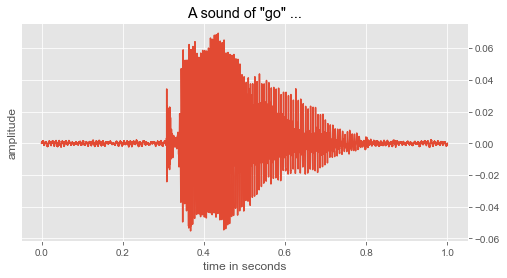

In [65]:

# ............................................................................


                                        # Plot a 'go' soundwave

goSample    = os.path.join(audioPth,
                           'go',
                           '00f0204f_nohash_1.wav')
(smp,smpR)  = librosa.load(goSample,sr=16000)


plt.figure(figsize=(8,4))
plt.plot(np.linspace(0,                 # Start
                     len(smp)/smpR,     # Stop (convert sample number into second)
                     len(smp)),         # Number of points
         smp)
plt.title('A sound of "go" ...')
plt.xlabel('time in seconds')
plt.ylabel('amplitude')

Inspecting data  ... 


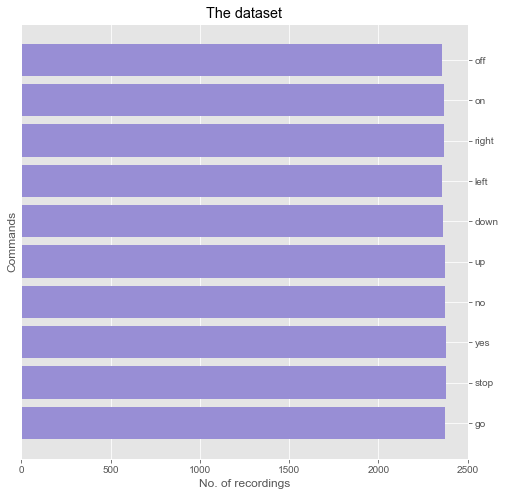

In [66]:
num_labels# ............................................................................

print("Inspecting data  ... ")
                                            # Inspect the data set

labels      = ["go",
               "stop",
               "yes", 
               "no", 
               "up", 
               "down", 
               "left", 
               "right", 
               "on", 
               "off"]

                                            # Check the number of records available in
                                            # each category
numOfRecords= []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
                                            # Get all the wave files in each directory
    
    numOfRecords.append(len(records))       # Get the number of wave files in each directory
    
    
plt.figure(figsize=(8,8))
plt.barh(np.arange(len(labels)), 
         numOfRecords,
         color="C2")
plt.xlabel('No. of recordings')
plt.ylabel('Commands')
plt.yticks(np.arange(len(labels)), labels)
plt.title('The dataset')
plt.show()

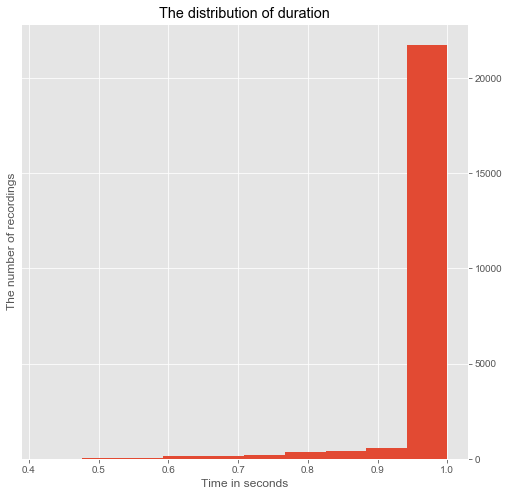

In [67]:
                                            # Check distribution of durations in 
                                            # the dataset
durations   = []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
                                            # Get all the wave files in each directory
    
    for rcd in records:
        (smpR,smp)  = wavfile.read(os.path.join(pth,rcd))
        
        durations.append(float(len(smp)/smpR))      
                                            # Get the duration for each wave file

plt.figure(figsize=(8,8))
plt.title('The distribution of duration')
plt.ylabel('The number of recordings')
plt.xlabel('Time in seconds')
durationHist    = plt.hist(durations)

In [68]:
# ............................................................................


                                            # Prepare dataset for training 
                                            # (Get only sample with a duration 
                                            # of 1 second)
print("Preparing dataset ... ")
allRecords  = []
allLabels   = []
alldata     = []
for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]

    for rcd in records:
        (smp,smpR)  = librosa.load(os.path.join(pth,rcd),sr=16000)
        dataSmp = smp[0]
        smp         = librosa.resample(smp,
                                       smpR, 
                                       resmpRate)
        if (len(smp)==inputLength): 
            allRecords.append(smp)
            allLabels.append(lbl)
            alldata.append(dataSmp)


Preparing dataset ... 


In [69]:
import pickle
f = open('data.pk', 'wb')
pickle.dump(allRecords, f)
f.close()

In [70]:
f = open('label.pk', 'wb')
pickle.dump(allLabels, f)
f.close()

In [75]:
allRecords  = np.array(allRecords).reshape(-1,inputLength,1)  

In [76]:
# ............................................................................


                                            # Prepare the label for training
                                            
le      = LabelEncoder()
lbls    = le.fit_transform(allLabels)
classes = list(le.classes_)                 # the output is a funny numpy str_ object
classes = [str(c) for c in classes]         # convert each output in the list to string
lbls    = to_categorical(lbls,num_classes=len(classes)) 

In [79]:
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [8]:
# ............................................................................

                                            # Split the data into training and 
                                            # validation set

(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(allRecords,
                           lbls,
                           stratify=lbls,
                           test_size=0.2,
                           random_state=229,
                           shuffle=True)

In [9]:
# ...........................................................................


                                            # Create the deep learning model
def createModel(inputSize):
    ipt = Input(shape=(inputSize,1))

    x   = Conv1D(8, 11, padding='valid', activation='relu')(ipt)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(16, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(32, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(64, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Flatten()(x)
    x   = Dense(256, activation='relu')(x)
    x   = Dropout(0.5)(x)
    
    x   = Dense(128, activation='relu')(x)
    x   = Dropout(0.5)(x)
    
    x   = Dense(len(classes), activation='softmax')(x)
    
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [10]:
                                        # Setup the models
model       = createModel(inputLength) # This is meant for training
modelGo     = createModel(inputLength) # This is used for final testing

model.summary()

plot_model(model, 
           to_file=modelname+'_plot.pdf', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1997, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1997, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1987, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxP

In [11]:
# .............................................................................


                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_loss', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]


In [12]:
# .............................................................................


                            # Fit the model
                            # This is where the training starts
model.fit(trDat, 
          trLbl, 
          validation_data=(vlDat, vlLbl), 
          epochs=100, 
          batch_size=32,
          shuffle=True,
          callbacks=callbacks_list)

Train on 17049 samples, validate on 4263 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
17049/17049 [==============================] - 62s 4ms/sample - loss: 2.1267 - acc: 0.1847 - val_loss: 1.8754 - val_acc: 0.2930
Epoch 2/100
17049/17049 [==============================] - 58s 3ms/sample - loss: 1.5620 - acc: 0.4118 - val_loss: 1.2909 - val_acc: 0.5649
Epoch 3/100
17049/17049 [==============================] - 61s 4ms/sample - loss: 1.2181 - acc: 0.5712 - val_loss: 1.0168 - val_acc: 0.6624
Epoch 4/100
17049/17049 [==============================] - 59s 3ms/sample - loss: 0.9927 - acc: 0.6579 - val_loss: 0.7906 - val_acc: 0.7312
Epoch 5/100
17049/17049 [==============================] - 58s 3ms/sample - loss: 0.8732 - acc: 0.7025 - val_loss: 0.6955 - val_acc: 0.7596
Epoch 6/100
17049/17049 [==============================] - 57s 3ms/sample - loss: 0.7957 - acc: 0.7299 - val_loss: 0.6941 - val_acc: 0.7628
Epoch 7/100
17049/17049 [==============================] - 59s 

Epoch 57/100
17049/17049 [==============================] - 65s 4ms/sample - loss: 0.3445 - acc: 0.8900 - val_loss: 0.3295 - val_acc: 0.8935
Epoch 58/100
17049/17049 [==============================] - 63s 4ms/sample - loss: 0.3244 - acc: 0.8908 - val_loss: 0.3334 - val_acc: 0.8940
Epoch 59/100
17049/17049 [==============================] - 62s 4ms/sample - loss: 0.3396 - acc: 0.8876 - val_loss: 0.3406 - val_acc: 0.8933
Epoch 60/100
17049/17049 [==============================] - 65s 4ms/sample - loss: 0.3274 - acc: 0.8918 - val_loss: 0.3360 - val_acc: 0.8921
Epoch 61/100
17049/17049 [==============================] - 65s 4ms/sample - loss: 0.3281 - acc: 0.8928 - val_loss: 0.3278 - val_acc: 0.8923
Epoch 62/100
17049/17049 [==============================] - 64s 4ms/sample - loss: 0.3172 - acc: 0.8948 - val_loss: 0.3572 - val_acc: 0.8855
Epoch 63/100
17049/17049 [==============================] - 65s 4ms/sample - loss: 0.3251 - acc: 0.8954 - val_loss: 0.3665 - val_acc: 0.8799
Epoch 64/100


In [13]:
# ......................................................................


                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [14]:
# .......................................................................


                            # Make classification on the test dataset
predicts    = modelGo.predict(vlDat)


                            # Prepare the classification output
                            # for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(vlLbl,axis=1)



testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=classes,digits=4))
print(confusion)

Best accuracy (on testing dataset): 89.14%
              precision    recall  f1-score   support

        down     0.8776    0.8837    0.8806       430
          go     0.8810    0.8810    0.8810       420
        left     0.8868    0.8684    0.8775       433
          no     0.8938    0.8619    0.8776       420
         off     0.8908    0.8368    0.8630       429
          on     0.9593    0.8955    0.9263       421
       right     0.9703    0.9095    0.9389       431
        stop     0.9045    0.9149    0.9097       435
          up     0.7898    0.9029    0.8426       412
         yes     0.8809    0.9583    0.9180       432

   micro avg     0.8914    0.8914    0.8914      4263
   macro avg     0.8935    0.8913    0.8915      4263
weighted avg     0.8938    0.8914    0.8917      4263

[[380  17   1   9   0   4   1   9   4   5]
 [ 24 370   1   9   1   0   1   5   8   1]
 [  1   2 376   7   2   0   1   6   8  30]
 [ 10  16   7 362   1   0   3   0   7  14]
 [  1   4   4   2 359   7 

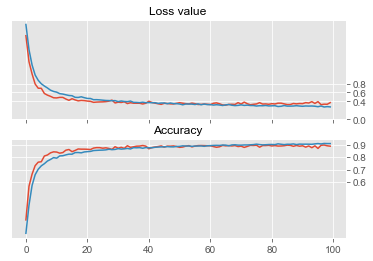

In [15]:
# ..................................................................
    


records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

In [16]:
# ............................................................................

                                            # Create a function to make prediction 
                                            # straightly from a wave file
                                            
def commandPred(file):
    (smp,smpR)  = librosa.load(file,sr=16000)
    smp         = librosa.resample(smp,
                                   smpR, 
                                   resmpRate)
    smp         = smp.reshape(-1,inputLength,1)
    pred        = modelGo.predict(smp)
    pred        = np.argmax(pred,axis=1)
    
    return classes[pred[0]]

In [17]:
# ............................................................................
    
wfile       = 'voice01.wav'
pred        = commandPred(wfile)
print("")
print("The command predicted from '%s' is '%s'." % (wfile,pred) )


The command predicted from 'voice01.wav' is 'right'.
